## MD simulation of folded protein

This is an MD run of the Trp cage protein starting from its NMR determined structure as provided by the protein databank (1L2Y). This run was performed at 325K to see if the protein is stable at these temperatures and also to get an estimate of the expected potential energy of the correctly folded protein.


<font color='red'>**Note:** *The following preamble is required to python modules to be imported from other directories in the notebook structure.*</font>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from helpers.GromacsHelpers import *

In [3]:
%matplotlib inline

Make a new scratch directory and move into it (gromacs creates a lot of files!). Note this is commented out as it only needs to be done once!

In [4]:
# !mkdir 1_scratch

In [5]:
cd 1_scratch

/home/pauls/honours/notebooks/1 - Trp Cage/1_scratch


Download the protein structure from the RCSB.

In [5]:
# !wget https://files.rcsb.org/download/1L2Y.pdb

In [6]:
gmx("pdb2gmx -f 1L2Y.pdb -o 1L2Y_processed.gro -ignh -water spce", "15\n")

Select the Force Field:
From '/usr/local/gromacs_gpu/share/gromacs/top':
 1: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)
 2: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)
 3: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)
 4: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)
 5: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)
 6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)
 7: AMBERGS force field (Garcia & Sanbonmatsu, PNAS 99, 2782-2787, 2002)
 8: CHARMM27 all-atom force field (CHARM22 plus CMAP for proteins)
 9: GROMOS96 43a1 force field
10: GROMOS96 43a2 force field (improved alkane dihedrals)
11: GROMOS96 45a3 force field (Schuler JCC 2001 22 1205)
12: GROMOS96 53a5 force field (JCC 2004 vol 25 pag 1656)
13: GROMOS96 53a6 force field (JCC 2004 vol 25 pag 1656)
14: GROMOS96 54a7

In [7]:
gmx("editconf -f 1L2Y_processed.gro -o 1L2Y_newbox.gro -c -d 1.0 -bt cubic")

Read 304 atoms
Volume: 0.001 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  2.299  2.012  1.378 (nm)
    diameter    :  2.392               (nm)
    center      :  0.010  0.002 -0.001 (nm)
    box vectors :  0.100  0.100  0.100 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.186  2.194  2.197 (nm)
new center      :  2.196  2.196  2.196 (nm)
new box vectors :  4.392  4.392  4.392 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :  84.74               (nm^3)


In [8]:
gmx("solvate -cp 1L2Y_newbox.gro -cs spc216.gro -o 1L2Y_solv.gro -p topol.top")

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 2679 solvent molecules to topology file (topol.top)


In [9]:
%%file ions.mdp
; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions (yes/no)

Writing ions.mdp


In [10]:
gmx("grompp -f ions.mdp -c 1L2Y_solv.gro -p topol.top -o ions.tpr")
gmx("genion -s ions.tpr -o 1L2Y_solv_ions.gro -p topol.top -pname NA -nname CL -nn 1", "13\n")

Analysing residue names:
There are:    20    Protein residues
There are:  2679      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.110 0.110 0.110
This run will generate roughly 1 Mb of data
Will try to add 0 NA ions and 1 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 1 solute molecules in topology file (topol.top)  by 0 NA and 1 CL ions.


In [11]:
%%file minim.mdp
; minim.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep     ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0    ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01      ; Energy step size
nsteps      = 50000     ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions (yes/no)

Writing minim.mdp


In [5]:
gmx("grompp -f minim.mdp -c 1L2Y_solv_ions.gro -p topol.top -o em.tpr")
gmx("mdrun -v -deffnm em")

Analysing residue names:
There are:    20    Protein residues
There are:  2678      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 40x40x40, spacing 0.110 0.110 0.110
This run will generate roughly 1 Mb of data



Statistics over 245 steps [ 0.0000 through 244.0000 ps ], 1 data sets
All statistics are over 194 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -127463       4000    10842.7   -26720.9  (kJ/mol)


/home/pauls/anaconda2/envs/gromacs/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


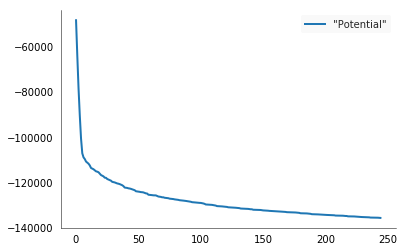

In [6]:
gmx("energy -f em.edr -o potential.xvg", "10\n")
plotFigure("potential.xvg")

Read 8339 atoms
Volume: 84.737 nm^3, corresponds to roughly 38100 electrons
No velocities found


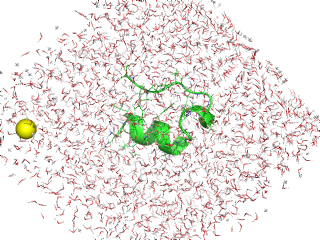

In [5]:
pymolPlotGro("em.gro")

In [9]:
%%file nvt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 50000     ; 2 * 50000 = 100 ps
dt          = 0.002     ; 2 fs

; Output control
nstxout     = 500       ; save coordinates every 1.0 ps
nstvout     = 500       ; save velocities every 1.0 ps
nstenergy   = 500       ; save energies every 1.0 ps
nstlog      = 500       ; update log file every 1.0 ps

; Bond parameters
continuation            = no        ; first dynamics run
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl      = no        ; no pressure coupling in NVT

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = yes       ; assign velocities from Maxwell distribution
gen_temp    = 325       ; temperature for Maxwell distribution
gen_seed    = -1        ; generate a random seed


Overwriting nvt.mdp


In [ ]:
gmx("grompp -f nvt.mdp -c em.gro -p topol.top -o nvt.tpr")
gmx("mdrun -v -deffnm nvt")

turning all bonds into constraints...
turning all bonds into constraints...
turning all bonds into constraints...
Analysing residue names:
There are:    20    Protein residues
There are:  2678      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 325 K
Calculated rlist for 1x1 atom pair-list as 1.038 nm, buffer size 0.038 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 28x28x28, spacing 0.157 0.157 0.157
This run will generate roughly 20 Mb of data


In [ ]:
gmx("energy -f nvt.edr -o temperature.xvg", "15\n")
plotFigure("temperature.xvg")

In [ ]:
%%file npt.mdp
define      = -DPOSRES  ; position restrain the protein
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 50000     ; 2 * 50000 = 100 ps
dt          = 0.002     ; 2 fs

; Output control
nstxout     = 500       ; save coordinates every 1.0 ps
nstvout     = 500       ; save velocities every 1.0 ps
nstenergy   = 500       ; save energies every 1.0 ps
nstlog      = 500       ; update log file every 1.0 ps

; Bond parameters
continuation            = yes       ; restarting acter NVT
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is on
pcoupl              = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype          = isotropic             ; uniform scaling of box vectors
tau_p               = 2.0                   ; time constant, in ps
ref_p               = 1.0                   ; reference pressure, in bar
compressibility     = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling    = com

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = no       ; Velocity generation is off


In [ ]:
gmx("grompp -f npt.mdp -c nvt.gro -t nvt.cpt -p topol.top -o npt.tpr")
gmx("mdrun -v -deffnm npt")

In [ ]:
gmx("energy -f npt.edr -o pressure.xvg", "16\n")
plotFigure("pressure.xvg")

In [ ]:
gmx("energy -f npt.edr -o density.xvg", "22\n")
plotFigure("density.xvg")

In [ ]:
%%file md.mdp
; Run parameters
integrator  = md        ; leap-frog integrator
nsteps      = 500000    ; 2 * 500000 = 1000 ps (1 ns)
dt          = 0.002     ; 2 fs

; Output control
nstxout     = 5000       ; save coordinates every 10.0 ps
nstvout     = 5000       ; save velocities every 10.0 ps
nstenergy   = 5000       ; save energies every 10.0 ps
nstlog      = 5000       ; update log file every 10.0 ps
nstxout-compressed  = 5000      ; save compressed coordinates every 10.0 ps
                                ; nstxout-compressed replaces nstxtcout
compressed-x-grps   = System    ; replaces xtc-grps

; Bond parameters
continuation            = yes       ; restarting acter NPT
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = all-bonds ; all bonds (even heavy atom-H bonds) constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy

; Neighborsearching
cutoff-scheme   = Verlet
ns_type         = grid      ; search neighboring grid cells
nstlist         = 10        ; 20 fs, largely irrelevant with Verlet
rcoulomb        = 1.0       ; short-range electrostatic cutoff (in nm)
rvdw            = 1.0       ; short-range van der Waals cutoff (in nm)

; Electrostatics
coulombtype     = PME   ; Particle Mesh Ewald for long-range electrostatics
pme_order       = 4     ; cubic interpolation
fourierspacing  = 0.16  ; grid spacing for FFT

; Temperature coupling is on
tcoupl      = V-rescale             ; modified Berendsen thermostat
tc-grps     = Protein Non-Protein   ; two coupling groups - more accurate
tau_t       = 0.1  0.1              ; time constant, in ps
ref_t       = 325  325              ; reference temperature, one for each group, in K

; Pressure coupling is on
pcoupl              = Parrinello-Rahman     ; Pressure coupling on in NPT
pcoupltype          = isotropic             ; uniform scaling of box vectors
tau_p               = 2.0                   ; time constant, in ps
ref_p               = 1.0                   ; reference pressure, in bar
compressibility     = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling    = com

; Periodic boundary conditions
pbc         = xyz       ; 3-D PBC

; Dispersion correction
DispCorr    = EnerPres  ; account for cut-off vdW scheme

; Velocity generation
gen_vel     = no       ; Velocity generation is off


In [ ]:
gmx("grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md_0_1.tpr")
gmx("mdrun -v -deffnm md_0_1")

In [ ]:
gmx("trjconv -s md_0_1.tpr -f md_0_1.xtc -o md_0_1_noPBC.xtc -pbc mol -ur compact", "0\n")
gmx("rms -s md_0_1.tpr -f md_0_1_noPBC.xtc -o rmsd.xvg -tu ns", "4\n4\n")
plotFigure("rmsd.xvg")

In [ ]:
gmx("energy -f md_0_1.edr -o pe.xvg", "10\n")
plotFigure("pe.xvg")

In [ ]:
gmx("trjconv -s md_0_1.tpr -f md_0_1_noPBC.xtc -o md_0_1.pdb -pbc nojump -dt 10", "1\n")

In [ ]:
pymolPlotStructure("md_0_1.pdb")

In [ ]:
pymolFlexibilityPlot("md_0_1.pdb")